In [1]:
import hopsworks
import pandas as pd
from sklearn.ensemble import IsolationForest
import numpy as np

project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/549021
2024-05-28 12:36:57,169 WARNING: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead

2024-05-28 12:36:57,195 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.


In [2]:
try: 
    feature_view = fs.get_feature_view(name="spot6e", version=1)
except:
    fg = fs.get_feature_group(name="spot6e", version=1)
    query = fg.select_all()
    feature_view = fs.create_feature_view(name="spot6e",
                                      version=1,
                                      description="sensor 6e",
                                      query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/549021/fs/544844/fv/spot6e/version/1


In [3]:
feature, labels = feature_view.training_data(
    description = 'spot6e training dataset',
)

features = feature[['x','y','z','temperature','magnitude']]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.63s) 
2024-05-28 12:37:22,415 WARNING: VersionWarning: Incremented version to `1`.



2024-05-28 12:37:24,600 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2024-05-28 12:37:24,863 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



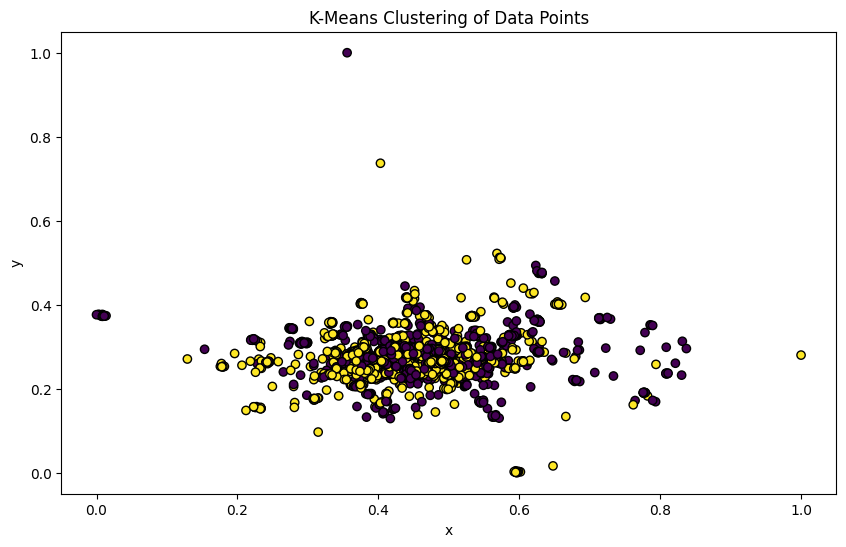

          x         y         z  temperature  magnitude  cluster
0  0.353094  0.349239  0.410926        0.600   0.644596        0
1  0.437858  0.226487  0.466350        0.700   0.678600        0
2  0.491420  0.263485  0.445764        0.600   0.713879        0
3  0.490380  0.265560  0.445764        0.700   0.713933        0
4  0.493500  0.266943  0.444181        0.775   0.715610        0


In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



features['magnitude'] = np.sqrt(features['x']**2 + features['y']**2 + features['z']**2)

kmeans = KMeans(n_clusters=2, random_state=42)  

kmeans.fit(features)

clusters = kmeans.predict(features)

features['cluster'] = clusters

plt.figure(figsize=(10, 6))
plt.scatter(features['x'], features['y'], c=features['cluster'], cmap='viridis', marker='o', edgecolor='k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering of Data Points')
plt.show()

print(features.head())

cluster_counts = features['cluster'].value_counts()
anomaly_cluster = cluster_counts.idxmin()

anomalies = features[features['cluster'] == anomaly_cluster]

anomaly_indices = anomalies.index

In [5]:
features.head(20)

,x,y,z,temperature,magnitude,cluster
0,0.353094,0.349239,0.410926,0.600,0.644596,0
1,0.437858,0.226487,0.466350,0.700,0.678600,0
2,0.491420,0.263485,0.445764,0.600,0.713879,0
3,0.490380,0.265560,0.445764,0.700,0.713933,0
4,0.493500,0.266943,0.444181,0.775,0.715610,0
5,0.628705,0.360996,0.092637,0.575,0.730869,0
6,0.483619,0.262794,0.441013,0.325,0.705295,1
7,0.386895,0.223721,0.491686,0.325,0.664451,1
8,0.477379,0.264523,0.442597,0.225,0.702677,1
9,0.491420,0.264523,0.446556,0.750,0.714757,0


In [6]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import os
import joblib
import shutil

In [7]:
mr = project.get_model_registry()

model_dir1="spot6e_k_nn"
if os.path.isdir(model_dir1) == False:
    os.mkdir(model_dir1)
joblib.dump(kmeans, model_dir1 + "/spot6e_k_nn.pkl")



spot6e= mr.python.create_model(
    version=1,
    name="spot6e_k_nn", 
    description="Anomaly detection- UML")

spot6e.save(model_dir1)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/32211 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/549021/models/spot6e_k_nn/1


Model(name: 'spot6e_k_nn', version: 1)